# CS524 Project: Flux Balance Analysis for Metabolic Networks

**About this notebook**

The notebook contains two parts:
- In the first part, I will go through and illustrate the problem settings, data processing,
model construction and post-solving analysis. 
- In the second part, I will wrap the whole procedure into a general solver application.
A user can use this to find solution to any organism in a list (yeast, mouse, E. Coli) or
compare performances.

---

## 1. Introduction
Biological systems has numerous interconnected
metabolic (chemical) reactions that convert nutrients into energy, biomass, and other prod-
ucts. Understanding how the reaction ﬂuxes are distributed across a metabolic network
is an important question in biology. Flux Balance Analysis (FBA) is a computational
method to model the reaction ﬂuxes in a metabolic network at steady state.1 It uses a
complete set of all reactions of a cell/organism, and formulate a linear program model to
optimize a biological objective such as growth rate, and hence obtaining a metabolic net-
work model with optimal ﬂux distribution. In this project, I will use the idea of FBA
to construct metabolic models using public data, and then perform subsequent analyses.


## 2. Date processing

### 2.1 The data pipeline
The data we use in this project comes from the BiGG Models [http://bigg.ucsd.edu/](http://bigg.ucsd.edu/).
These are raw data come from experimental measurement of all metabolites (i.e. intermeidate substrates) and 
all reactions and their identities.

The common objective of optimization for simple organisms are defined as "biomass accumulation". This is an idea similar to taking into some nutrient and grow, and it wants to maximize the growth rate. People have defined some biomass reaction which transform certain amounts of a set of metabolites into "biomass".
However, for more complex living systems, like human, there is not a simple objective like this. Researchers are likely to define some objective of interest, like maximizing "something", based on what they are studying, so a biomass reaction is not contained. In this project, I only fetch and use the organisms that have a biomass objective.

### Part A. The process of data pipeline and model construction

In [1]:
import requests
import json
import pandas as pd
import os

import gamspy as gp 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# select one model
NAME = "E. coli (core)"

names_dict = {"E. coli (core)":"e_coli_core",
         "E. coli": "iAF1260",
         "Brewer's yeast (S. cerevisiae)": "iMM904", 
         "House mouse (M. musculus)": "iMM1415"}

def fetch_data(model_name, save_loc=None):
    url = f"http://bigg.ucsd.edu/static/models/{model_name}.json"
    response = requests.get(url)
    if save_loc:
        with open(save_loc, "wb") as f:
            f.write(response.content)
    return response.json()

if os.path.exists(f"data/{names_dict[NAME]}.json"):
    with open(f"data/{names_dict[NAME]}.json", "r") as f:
        data_json = json.load(f)
        print("Loaded from local file.")
else:
    if not os.path.exists("data"):
        os.makedirs("data")
    data_json = fetch_data(names_dict[NAME], f"data/{names_dict[NAME]}.json")
    print("Fetched from web and saved locally.")
    
data_json.keys()

Loaded from local file.


dict_keys(['metabolites', 'reactions', 'genes', 'id', 'compartments', 'version'])

In [3]:

metabolites_df = pd.DataFrame(data_json['metabolites'])
metabolites_df[['id', 'name', 'formula']].head()

,id,name,formula
0,glc__D_e,D-Glucose,C6H12O6
1,gln__L_c,L-Glutamine,C5H10N2O3
2,gln__L_e,L-Glutamine,C5H10N2O3
3,glu__L_c,L-Glutamate,C5H8NO4
4,glu__L_e,L-Glutamate,C5H8NO4


In [4]:
reactions_df = pd.DataFrame(data_json['reactions'])
reactions_df[['id', 'name', 'metabolites', 'lower_bound', 'upper_bound']][15:20]

,id,name,metabolites,lower_bound,upper_bound
15,ATPM,ATP maintenance requirement,"{'adp_c': 1.0, 'atp_c': -1.0, 'h2o_c': -1.0, '...",8.39,1000.0
16,PPCK,Phosphoenolpyruvate carboxykinase,"{'adp_c': 1.0, 'atp_c': -1.0, 'co2_c': 1.0, 'o...",0.00,1000.0
17,ACt2r,Acetate reversible transport via proton symport,"{'ac_c': 1.0, 'ac_e': -1.0, 'h_c': 1.0, 'h_e':...",-1000.00,1000.0
18,PPS,Phosphoenolpyruvate synthase,"{'amp_c': 1.0, 'atp_c': -1.0, 'h2o_c': -1.0, '...",0.00,1000.0
19,ADK1,Adenylate kinase,"{'adp_c': 2.0, 'amp_c': -1.0, 'atp_c': -1.0}",-1000.00,1000.0


In [5]:
reactions_df = pd.DataFrame(data_json['reactions'])

reaction_mat_df = pd.concat([reactions_df[['id', 'name']],   
           pd.DataFrame(reactions_df['metabolites'].to_list()).fillna(0) ],
           axis=1)
# find biomass reaction
biomass_rxn_idx = reaction_mat_df['name'].str.contains('biomass', case=False)
# replace id to "biomass"
reaction_mat_df.at[biomass_rxn_idx.idxmax(), 'id'] = 'biomass'
reactions_df.at[biomass_rxn_idx.idxmax(), 'id'] = 'biomass'
# get columes other than id name
display(reaction_mat_df[reaction_mat_df.columns.difference(['id', 'name'])].head())

# Convert wide format to long format
reaction_mat_long = pd.melt(
    reaction_mat_df, 
    id_vars=['id'], 
    value_vars=[col for col in reaction_mat_df.columns if col not in ['id', 'name']],
    var_name='metabolite', 
    value_name='coefficient'
)

# Display the result
print(f"Shape: {reaction_mat_long.shape}")
reaction_mat_long.columns = ['rxn', 'metabolite', 'coefficient']
reaction_mat_long.head(5)
reactions_df.rename(columns={'id':'rxn'}, inplace=True)

,13dpg_c,2pg_c,3pg_c,6pgc_c,6pgl_c,ac_c,ac_e,acald_c,acald_e,accoa_c,...,pyr_e,q8_c,q8h2_c,r5p_c,ru5p__D_c,s7p_c,succ_c,succ_e,succoa_c,xu5p__D_c
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shape: (6840, 3)


## 3. The optimization problem

### 3.1 FBA
In this problem setting, we have metabolites $\{m_j\} \ (i=1,2,...M)$, reactions $\{r_i\} \ (j=1,2,...R)$.
Each reaction is consuming and producing some metabolites, with some given chemical ratio, which is called 
the stoichiometric coefficients. We define the **stoichiometric coefficients** $s_{ij}$ is the amount of 
$m_j$ produced by **one unit of forward reaction** $r_i$. We also have some artificial "reactions": (1) exchanges: the reaction that only produce (or its reverse way consumes) a metabolite, which corresponds to
processes like getting $\mathrm O_2$ from the outside of the cell; and (2) a special "biomass" reaction, which is used 
to define the objective.

The decision variables are the "flux" of each reaction $r_i$, which corresponds to the reaction rate (speed), denoted $v_i$. The objective is the flux of biomass reaction, $v_\text{biomass}$ (growth rate). The constraints applied in FBA is from that idea that the cell should be in a steady state - any metabolites should keep a stable concentration, instead of building up or running out (note: building-up biomass is not include in metabolites, and all substances that have an input source, e.g. oxygen, is not included in metabolites neither). A cell is like a factory, producing at a constant rate. This mass **balance condition** is written as:

$$ \frac{d}{dt}[m_j] =  \sum_i s_{ij} v_i = 0, \qquad \forall j =1,2,...,M$$

For each metabolite, the reactions producing it and consuming it have a net rate of 0.

In addition, fluxes have constraints from thermodynamics, having both upperbound and lowerbound. $v_i$ can be negative, because the reactions in biological systems are usually reversible.

$$ lb_i < v_i < ub_i $$

In [37]:
gc = gp.Container()

# define sets
metabolite = gp.Set(gc, 'metabolite', description="metabolites", records=metabolites_df['id'])
rxn = gp.Set(gc, 'rxn', description="reactions", records=reaction_mat_df['id'])

# stoichiometric coefficients used for flux balance constraints
stoichiometry = gp.Parameter(gc, 'stoichiometry', description="stoichiometric coefficients",
                     domain=[rxn, metabolite], records=reaction_mat_long)

reaction_ub = gp.Parameter(gc, 'reaction_ub', description="reaction upper bounds",
                          domain=[rxn],
                          records=reactions_df[['rxn', 'upper_bound']])
reaction_lb = gp.Parameter(gc, 'reaction_lb', description="reaction lower bounds",
                          domain=[rxn],
                          records=reactions_df[['rxn', 'lower_bound']])

In [ ]:
# variables
vflux = gp.Variable(gc, 'flux', domain=rxn, description="reaction fluxes")

# bounds - CRITICAL: These must be set for FBA to work!
vflux[rxn].lo = reaction_lb[rxn]
vflux[rxn].up = reaction_ub[rxn]

# constraints
mass_balance = gp.Equation(gc, 'flux_balance',
                            domain=metabolite,)
mass_balance[metabolite] = gp.Sum(rxn, stoichiometry[rxn, metabolite] * vflux[rxn]) == 0

growth_rate = gp.Variable(gc, 'growth_rate', description="growth rate")
def_growth_rate = gp.Equation(gc, 'define_growth_rate')
def_growth_rate[:] = vflux['biomass'] == growth_rate

fba = gp.Model(gc, 'FBA_model', description="Flux Balance Analysis model",
               objective = growth_rate,
               equations = [mass_balance, def_growth_rate],
               sense = gp.Sense.MAX,
               problem=gp.Problem.LP,
               )

fba.solve(options=gp.Options(equation_listing_limit=0))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,0.873922,73,96,LP,CPLEX,0.004


In [123]:
display(vflux.records)

,rxn,level,marginal,lower,upper,scale
0,PFK,7.477382,0.000000,0.0,1000.0,1.0
1,PFL,0.000000,-0.007639,0.0,1000.0,1.0
2,PGI,4.860861,0.000000,-1000.0,1000.0,1.0
3,PGK,-16.023526,0.000000,-1000.0,1000.0,1.0
4,PGL,4.959985,0.000000,0.0,1000.0,1.0
...,...,...,...,...,...,...
90,NADH16,38.534610,0.000000,0.0,1000.0,1.0
91,NADTRHD,0.000000,-0.001273,0.0,1000.0,1.0
92,NH4t,4.765319,0.000000,-1000.0,1000.0,1.0
93,O2t,21.799493,0.000000,-1000.0,1000.0,1.0


A visualization of the fluxes through the reactions in the model:

While it is possible to show all non-zero values for this small model, we are only able to show a subset for larger models.

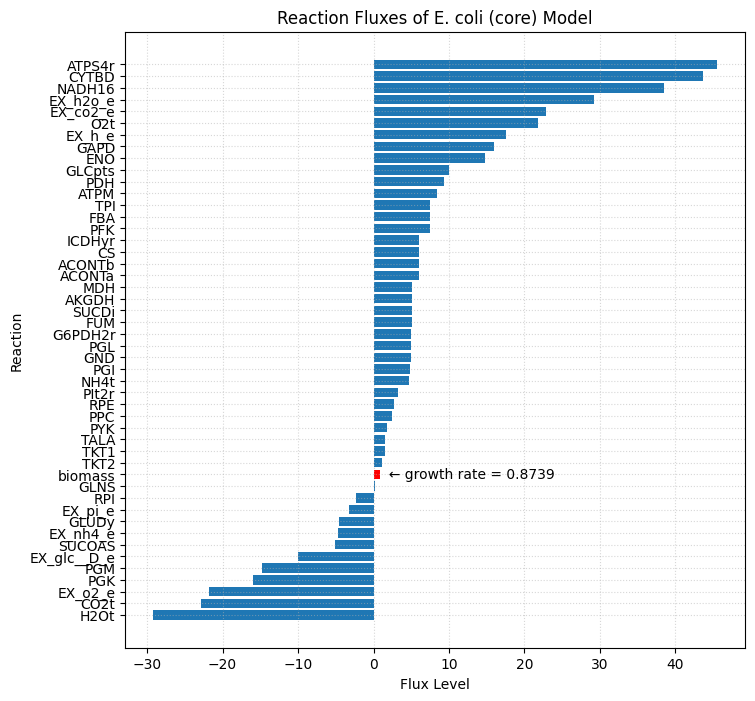

In [120]:
# Sort by level and create horizontal bar plot with biomass highlighted
flux_data = vflux.l.records.sort_values('level', ascending=True)
colors = ['red' if rxn == 'biomass' else 'C0' for rxn in flux_data['rxn']]

# Create the plot
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.barh(flux_data['rxn'], flux_data['level'], color=colors)
    ax.set_xlabel('Flux Level')
    ax.text(flux_data[flux_data['rxn'] == 'biomass']['level'].values[0],
            'biomass',
            '  ← growth rate = {:.4f}'.format(fba.objective_value),
            va='center',
            fontsize=10)
    ax.set_ylabel('Reaction')
    ax.set_title(f'Reaction Fluxes of {NAME} Model')
    ax.grid(True, linestyle=':', alpha=0.5)
#plt.tight_layout()
plt.show()

### 3. 1 Flux Variability Analysis

In [8]:
stoichiometry.records[(stoichiometry.records['rxn']=='biomass') & (stoichiometry.records['value']!=0) ]

,rxn,metabolite,value
24,biomass,adp_c,59.8100
119,biomass,atp_c,-59.8100
214,biomass,f6p_c,-0.0709
404,biomass,h_c,59.8100
499,biomass,accoa_c,-3.7478
594,biomass,coa_c,3.7478
784,biomass,pyr_c,-2.8328
879,biomass,g6p_c,-0.2050
1069,biomass,3pg_c,-1.4960
1354,biomass,h2o_c,-59.8100


In [9]:
print(reaction_mat_df.shape)
print(reaction_mat_df.columns[:10])
reaction_mat_df.iloc[:3, :5]

(95, 74)
Index(['id', 'name', 'adp_c', 'atp_c', 'f6p_c', 'fdp_c', 'h_c', 'accoa_c',
       'coa_c', 'for_c'],
      dtype='object')


,id,name,adp_c,atp_c,f6p_c
0,PFK,Phosphofructokinase,1.0,-1.0,-1.0
1,PFL,Pyruvate formate lyase,0.0,0.0,0.0
2,PGI,Glucose-6-phosphate isomerase,0.0,0.0,1.0
